In [1]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from openTSNE import TSNE
import os

In [2]:
df = pd.read_pickle("../data/text/data_with_embeds.pkl")

In [3]:
df.head()

,lang,title,summary,article_count,event_date,title_embed,summary_embed
id,,,,,,,
e_11,eng,Bombing survivor and nurse to wed,A man seriously wounded in the Boston bombing ...,7,16057,"[0.47470707, -0.08501352, 0.26899937, -0.36353...","[0.3377615, -0.26158097, 0.3140225, -0.2120716..."
e_10,eng,Trade Idea: GBP/USD - Sell at 1.6450,Although the British pound rallied to 1.6485 y...,221,16058,"[0.17094071, -0.18888026, 0.28712985, -0.36104...","[0.1786896, -0.11662727, 0.19326286, -0.20948,..."
e_13,eng,Too cool for Yule? Have a hipster Christmas in...,"Unlike you, hipsters don't want any old Christ...",9,16059,"[0.2537402, -0.032281302, 0.37904784, -0.31818...","[0.026874868, -0.09318099, 0.03552014, -0.0260..."
e_12,eng,Opening Bell: Cues that will help you trade be...,"The Sensex plunged 210.03 points to 20,715.58 ...",1,16054,"[0.23880291, 0.03649398, 0.32137018, -0.170995...","[0.46094257, -0.36103615, 0.31917268, -0.60180..."
e_15,eng,On Colorado shooter's arm...,(CNN) -- Colorado shooter Karl Pierson had wri...,8,16057,"[0.3985864, -0.06734807, 0.40732777, -0.461210...","[0.5053371, -0.062929116, 0.27972195, -0.43177..."


In [4]:
# graph = pickle.load(open("../data/graphs/100_concepts_similar_llm_noUnknown.pkl", "rb"))

In [5]:
# find percentage of rows with >= 20 articles
print(f"{np.sum(df['article_count'] >= 20) / df.shape[0] * 100:.2f}% of rows have >= 20 articles")

12.92% of rows have >= 20 articles


In [6]:
event_dates = df['event_date'].values.reshape(-1, 1)

x = np.concatenate([event_dates, df['title_embed'].tolist(), df['summary_embed'].tolist()], axis=1)
y = df['article_count'].apply(lambda x: 'important' if x >= 20 else 'not_important')

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [8]:
print("%d training samples" % x_train.shape[0])
print("%d test samples" % x_test.shape[0])

155248 training samples
38813 test samples


In [9]:
tsne = TSNE(
    perplexity=30,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)

In [ ]:
# check if train_tsne.pkl exists
if os.path.exists("../data/text/train_tsne.pkl"):
    print("Loading train_tsne.pkl")
    embedding_train = pickle.load(open("../data/text/train_tsne.pkl", "rb"))
    embedding_test = pickle.load(open("../data/text/test_tsne.pkl", "rb"))
else:
    print("Fitting train TSNE")
    embedding_train = tsne.fit(x_train)
    pickle.dump(embedding_train, open("../data/text/train_tsne.pkl", "wb"))
    embedding_test = embedding_train.transform(x_test)
    pickle.dump(embedding_test, open("../data/text/test_tsne.pkl", "wb"))


Fitting train TSNE
--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, n_jobs=8, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using Annoy approximate search using euclidean distance...


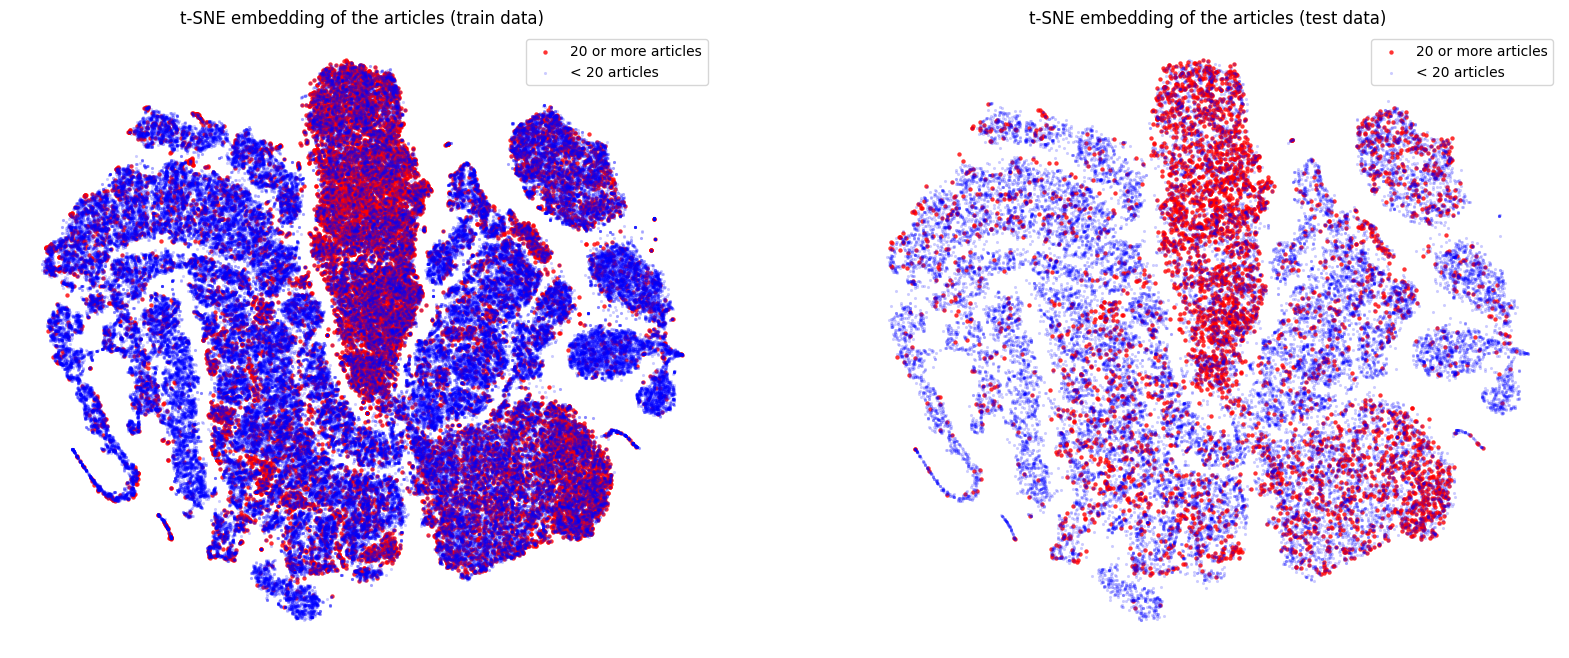

In [34]:
plt.figure(figsize=(20, 8))

# Training data
# Plot important (red) points

plt.subplot(121)

mask = y_train == 'important'
plt.scatter(embedding_train[mask, 0], embedding_train[mask, 1], 
            c='red', alpha=0.8, s=10, linewidths=0, label="20 or more articles")

# Plot non-important (blue) points with higher opacity
plt.scatter(embedding_train[~mask, 0], embedding_train[~mask, 1], 
            c='blue', alpha=0.2, s=5, linewidths=0, label="< 20 articles")

plt.axis('off')
plt.title("t-SNE embedding of the articles (train data)")
plt.legend()

# Test data
plt.subplot(122)

mask = y_test == 'important'
plt.scatter(embedding_test[mask, 0], embedding_test[mask, 1], 
            c='red', alpha=0.8, s=10, linewidths=0, label="20 or more articles")

# Plot non-important (blue) points with higher opacity
plt.scatter(embedding_test[~mask, 0], embedding_test[~mask, 1], 
            c='blue', alpha=0.2, s=5, linewidths=0, label="< 20 articles")

plt.axis('off')
plt.title("t-SNE embedding of the articles (test data)")
plt.legend()


# # Train and test
# 
# plt.subplot(223)
# 
# mask = y_train == 'important'
# plt.scatter(embedding_train[mask, 0], embedding_train[mask, 1], 
#             c='red', alpha=0.8, s=10, linewidths=0, label="train")
# 
# mask = y_test == 'important'
# plt.scatter(embedding_test[mask, 0], embedding_test[mask, 1], 
#             c='blue', alpha=0.8, s=10, linewidths=0, label="test")
# 
# plt.axis('off')
# plt.title("t-SNE embedding of the articles (train and test data)")
# 
# plt.legend()

plt.show()

In [29]:
from sklearn.cluster import DBSCAN

# The epsilon parameter needs to be set appropriately. It is the maximum distance between two samples 
# for one to be considered as in the neighborhood of the other. This is not a trivial parameter to set,
# and you might need to experiment with it to find a value that correctly identifies the clusters in your data.
eps_value = 1  # This is just a starting value, you will likely need to adjust it

# The min_samples parameter is the number of samples in a neighborhood for a point to be considered as a core point.
min_samples_value = 10  # This is just a starting value, you will likely need to adjust it

# Instantiate DBSCAN with the chosen parameters
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)

# Fit the model and predict clusters
clusters = dbscan.fit_predict(embedding_train)

# The number of clusters will be the number of unique labels, ignoring the noise if present
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)

# Now you can add the count of clusters to your plot or analyze it further
print('Estimated number of clusters: %d' % n_clusters)

Estimated number of clusters: 78


In [24]:
# color the points according to the cluster

plt.figure(figsize=(20, 8))

for i in range(n_clusters):
    mask = clusters == i
    plt.scatter(embedding_train[mask, 0], embedding_train[mask, 1], 
                alpha=0.8, s=10, linewidths=0, label=f"cluster {i}")
    
plt.axis('off')
plt.title("t-SNE embedding of the articles (train data)")
plt.legend()
plt.show()

(155248,)